<h2>Initializing</h2>
<h5>Importing dependencies and reading datasets</h5>

In [27]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
# Estimators
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
train_data = pd.read_csv('titanic_train.csv', index_col = 'PassengerId')
test_data = pd.read_csv('titanic_test.csv', index_col='PassengerId')

y_train = train_data.Survived
train_data.drop(['Survived'], axis=1, inplace=True)

<h3> Dataset visualization </h3>
<h5> Name and ticket shouldn't be relevant since each passenger has a unique value of those </h5>

In [46]:
train_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h3> Missing values check </h3>
<h5> As seen below, Cabin has 77% of missing values, which is not good for imputing, so it must be better to remove it</h5>

In [4]:
pd.set_option('display.float_format','{:.3%}'.format)
missing = pd.DataFrame(data={'count': train_data.isnull().sum(), 'percent': train_data.isnull().sum() / train_data.index.size})
pd.concat([missing, pd.DataFrame(data={'count': train_data.index.size, 'percent': 1}, index=['Total'])])

,count,percent
Pclass,0,0.000%
Name,0,0.000%
Sex,0,0.000%
Age,177,19.865%
SibSp,0,0.000%
Parch,0,0.000%
Ticket,0,0.000%
Fare,0,0.000%
Cabin,687,77.104%
Embarked,2,0.224%


<h5> On test data, Fare has missing values, although there wasn't a single one missing in training data (the opposite for Embarked)</h5>

In [5]:
missing = pd.DataFrame(data={'count': test_data.isnull().sum(), 'percent': test_data.isnull().sum() / test_data.index.size})
pd.concat([missing, pd.DataFrame(data={'count': test_data.index.size, 'percent': 1}, index=['Total'])])

,count,percent
Pclass,0,0.000%
Name,0,0.000%
Sex,0,0.000%
Age,86,20.574%
SibSp,0,0.000%
Parch,0,0.000%
Ticket,0,0.000%
Fare,1,0.239%
Cabin,327,78.230%
Embarked,0,0.000%


<h3> Categorical values consistency </h3>
<h5> Now we make sure that all the categorical data have the same unique values (i.e. test data has no category that is not present in the train data)</h5>

In [6]:
pd.set_option('display.float_format', None)
categorical_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
uniques_train = {key:train_data[key].value_counts() for key in categorical_cols}
uniques_test = {key:train_data[key].value_counts() for key in categorical_cols}
all([(uniques_train[key].index == uniques_test[key].index).tolist() for key in categorical_cols])

True

<h2> Preprocessing data </h2>
<h5> Now we can properly start preprocessing data</h5>

In [7]:
cols_to_drop = ['Name', 'Ticket', 'Cabin']
numerical_cols = ['Age', 'Fare']
object_cols = [col for col in categorical_cols if train_data[col].dtype == 'object']
# Categorical columns that are already encoded (0,1,2...)
categorical_cols = list(set(categorical_cols) - set(object_cols))

numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                        ('scaler', StandardScaler())])
categorical_imputer = SimpleImputer(strategy='most_frequent')
object_transformer = Pipeline(steps=[('imputer', categorical_imputer),
                                     ('OH', OneHotEncoder(sparse=True, drop='if_binary'))])

preprocessing = ColumnTransformer(transformers=[('to_drop', 'drop', cols_to_drop),
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_imputer, categorical_cols),
                                                ('obj', object_transformer, object_cols)])

<h2> Modelling </h2>
<h5> Since we have only a few features, no feature selection will be used, so we jump to modelling. Now we test different estimators to enhace scoring using Cross Validation </h5>

In [42]:
# CV TODO
clf = Pipeline(steps=[('prep', preprocessing),
                      ('model', DummyClassifier())])
params= [{'model':[SVC()],
          'model__C': np.logspace(0,3,4),
          'model__gamma': np.logspace(-3,0,4)},
         {'model': [LinearSVC()],
          'model__dual': [True, False],
          'model__C': np.logspace(0,3,4)},
         {'model': [DecisionTreeClassifier()],
          'model__max_depth': np.linspace(20,100, 3, dtype=np.int16)},
         {'model': [RandomForestClassifier()],
          'model__n_estimators': np.linspace(10,1000,5, dtype=np.int16)},
         {'model': [XGBClassifier()],
          'model__n_estimators': np.linspace(100,1000,5, dtype=np.int16),
          'model__learning_rate': np.linspace(0.05, 0.2, 4)}]
grid_search = GridSearchCV(clf, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(train_data, y_train)

best_model = grid_search.best_estimator_
# check the 'grid searched' model
best_model['model']

SVC(C=1000.0, gamma=0.01)

<h3> Evaluation </h3>
<h5> Score the model chosen during Modelling phase (different scorings can be used here)</h5>

In [44]:
score_name = 'accuracy'    # Change this to view different informations
score = cross_val_score(best_model, train_data, y_train, scoring=score_name, cv=5)
print(f"{score_name}: {score.mean():.2f} ± {score.std():.2f}")

accuracy: 0.83 ± 0.03


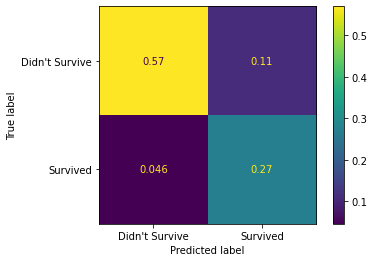

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

# Unfortanely there's no access to the y_test, so we use train data just to have a look
cm = confusion_matrix(best_model.predict(train_data), y_train, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['Didn\'t Survive', 'Survived']).plot()

<h2> Output </h2>
<h5> Make predictions and save properly as a .csv file that can be submitted to Kaggle competitions </h5>

In [ ]:
predictions = clf.predict(test_data)

output = pd.DataFrame(data={'PassengerId': test_data.index,
                            'Survived': predictions})
output.to_csv('submission.csv', index=False)